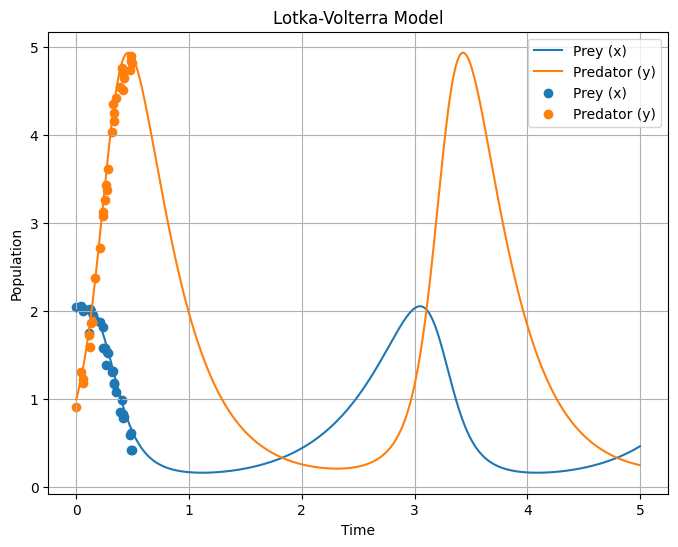

0
Epoch 0, Loss: 14.595734596252441
Physics Loss: 0.09906783699989319
Data Loss: 14.595635414123535


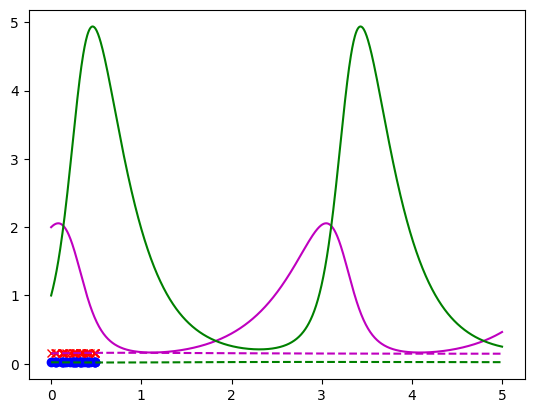

1000
Epoch 1000, Loss: 0.03250507265329361
Physics Loss: 17.359703063964844
Data Loss: 0.015145370736718178


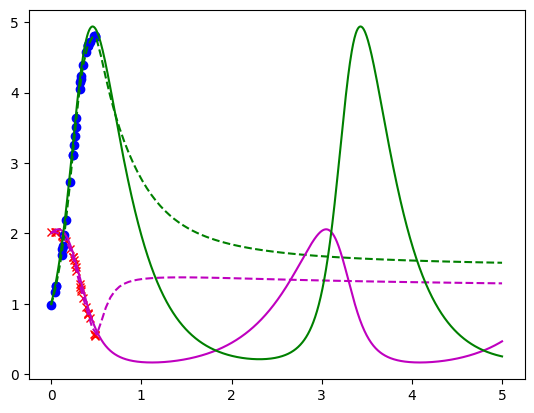

2000
Epoch 2000, Loss: 0.030755609273910522
Physics Loss: 16.568103790283203
Data Loss: 0.014187505468726158


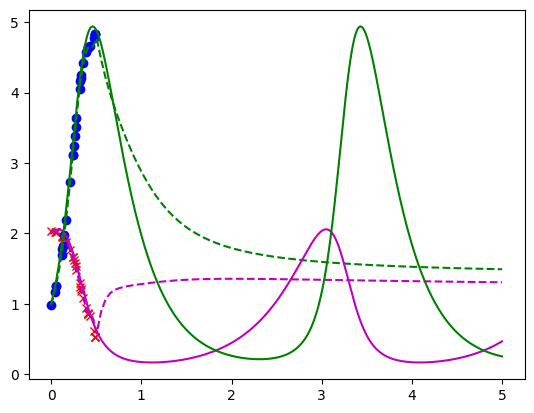

3000
Epoch 3000, Loss: 0.031802453100681305
Physics Loss: 16.710773468017578
Data Loss: 0.015091678127646446


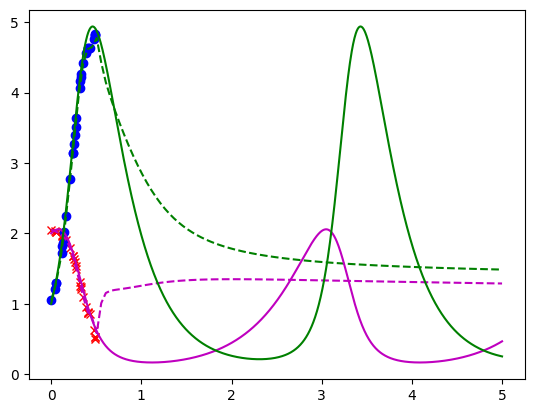

4000
Epoch 4000, Loss: 0.027912676334381104
Physics Loss: 14.891960144042969
Data Loss: 0.013020714744925499


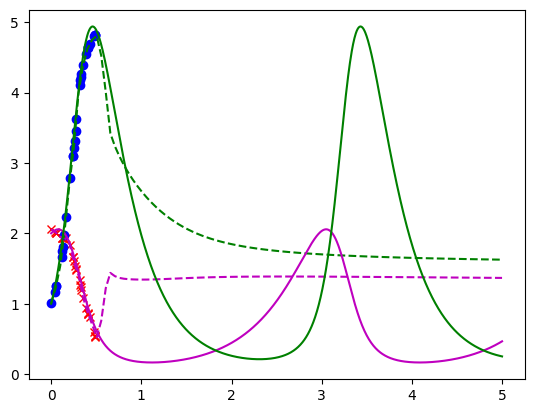

5000
Epoch 5000, Loss: 0.02705695852637291
Physics Loss: 14.501472473144531
Data Loss: 0.012555485591292381


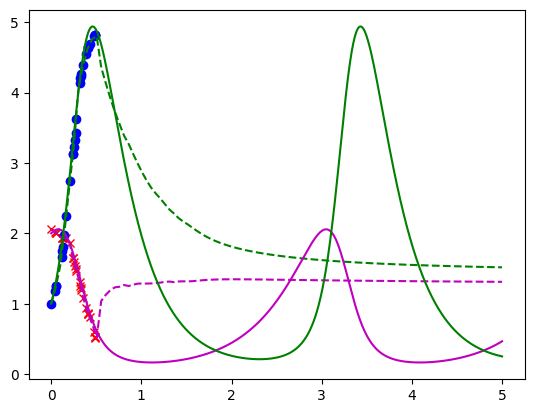

6000
Epoch 6000, Loss: 0.018346797674894333
Physics Loss: 6.927116394042969
Data Loss: 0.011419681832194328


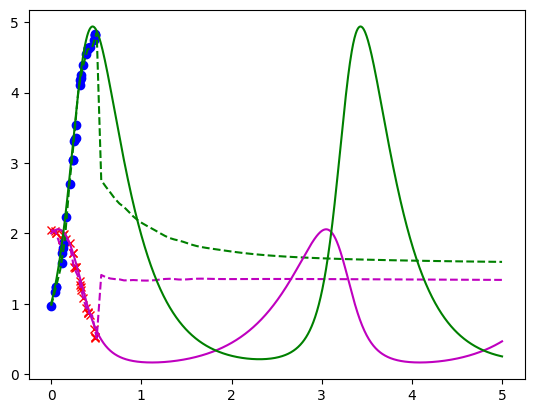

7000
Epoch 7000, Loss: 0.014449205249547958
Physics Loss: 5.07164192199707
Data Loss: 0.009377562440931797


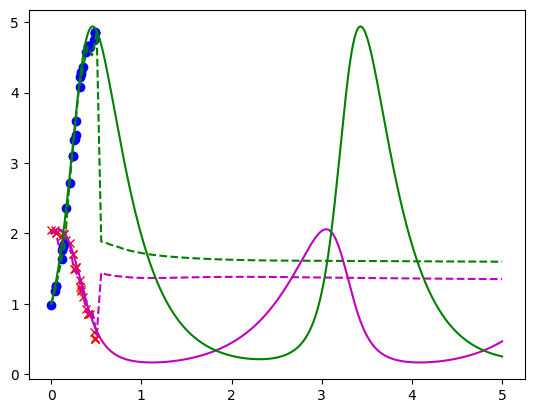

8000
Epoch 8000, Loss: 0.010014825500547886
Physics Loss: 3.024867534637451
Data Loss: 0.006989957764744759


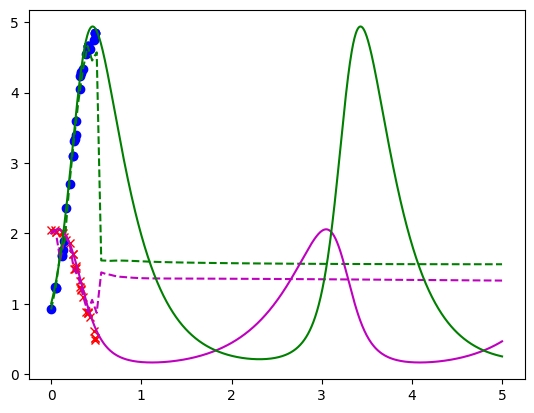

9000
Epoch 9000, Loss: 0.01860354095697403
Physics Loss: 10.553717613220215
Data Loss: 0.008049823343753815


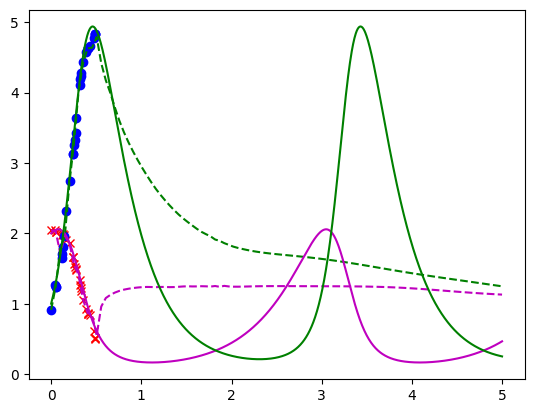

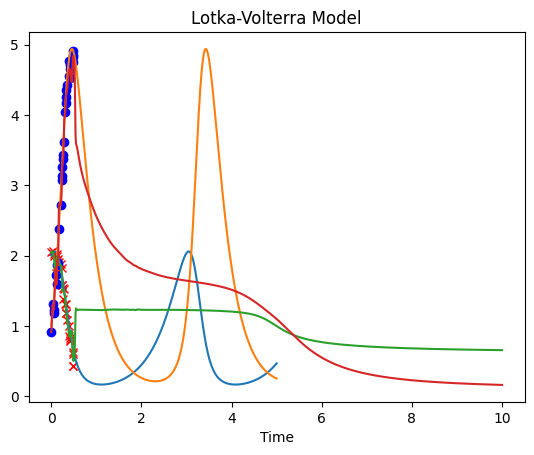

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# predator prey differential equation 
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y = y
    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y
    return [dx_dt, dy_dt]

# Parameters for lotka voltera
alpha = 2
beta = 4/3
delta = 4
gamma = 3

# Initial values for predator and prey populations 
x0 = 2  # Initial prey population
y0 = 1   # Initial predator population
initial_conditions = [x0, y0]

# Time points
t = np.linspace(0, 5, 1000)  # Time span

# Solve the differential equations
solution = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))

# Generate training data (based on noisy data or the true solution)
# training_t, training_y(prey, predator) noisy with gaussian, true_solution
pool = range(0,100)
idx = np.random.choice(pool, 30, replace=True)
training_t = t[idx]
# reshape to (100, 1)
training_t = training_t[:, np.newaxis]
true_data = solution[idx]
noise = np.random.normal(-0.1, 0.1, true_data.shape)
training_y = true_data + noise

# plot the training data and the true solution
plt.figure(figsize=(8, 6))
plt.plot(t, solution[:, 0], label='Prey (x)')
plt.plot(t, solution[:, 1], label='Predator (y)')
plt.scatter(training_t, training_y[:, 0], label='Prey (x)')
plt.scatter(training_t, training_y[:, 1], label='Predator (y)')
plt.title('Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

# Nerual network model, uses pytorch neural netowrk model
class PINNModel(nn.Module):
    # our neural network uses 6 layers with 256 neurons 
    def __init__(self):
        super(PINNModel, self).__init__()
        self.dense1 = nn.Linear(1, 256)  # 1 Input: time
        self.dense2 = nn.Linear(256, 256) 
        self.dense3 = nn.Linear(256, 256)
        self.dense4 = nn.Linear(256, 256)
        self.dense5 = nn.Linear(256, 256)
        self.dense6 = nn.Linear(256, 2)  # 2 Outputs: prey, predator

    def forward(self, t):
        t = t.view(-1,1)
        x = torch.tanh(self.dense1(t))
        x = torch.tanh(self.dense2(x))
        x = torch.tanh(self.dense3(x))
        x = torch.tanh(self.dense4(x))
        x = torch.tanh(self.dense5(x))
        sol = self.dense6(x)
        return sol
    
#Convert training data to np ndarray
if (type(training_t) is np.ndarray):
    training_t = torch.tensor(training_t, requires_grad=True, dtype=torch.float32)
    training_y = torch.tensor(training_y, requires_grad=True, dtype=torch.float32)
    true_data = torch.tensor(true_data, dtype=torch.float32)

prey_sample, pred_sample = torch.split(training_y, 1, dim=1)

# Instantiate the PINN model and define optimizer
model = PINNModel()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# time grid to test phys loss
t_phys = torch.linspace(0,5,100, requires_grad=True)

# Training loop
num_epochs = 10000  # Adjust as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions_data = model(training_t)
    prey_data, pred_data = torch.split(predictions_data, 1, dim=1)

    predictions_phys = model(t_phys)
    predictions_phys = predictions_phys.requires_grad_()

    dxdt = torch.autograd.grad(predictions_phys[:,0], t_phys, grad_outputs=torch.ones_like(predictions_phys[:,0]), create_graph=True)
    dydt = torch.autograd.grad(predictions_phys[:,1], t_phys, grad_outputs=torch.ones_like(predictions_phys[:,1]), create_graph=True)
    
    dxdt = dxdt[0]
    dydt = dydt[0]

    prey_phys, pred_phys = torch.split(predictions_phys, 1, dim=1)

    data_loss = torch.mean((prey_data - prey_sample)**2) + torch.mean((pred_data - pred_sample)**2)
    phys_loss = torch.mean((dxdt - alpha * prey_phys+ beta * prey_phys * pred_phys)**2) + torch.mean((dydt - gamma * prey_phys * pred_phys + delta * pred_phys)**2)
    loss = data_loss + 0.001*phys_loss

    if epoch % 1000 == 0:
        print(epoch)
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        print(f'Physics Loss: {phys_loss}')
        print(f'Data Loss: {data_loss}')
        plt.plot(training_t.detach().numpy(), prey_data.detach().numpy(),'rx')
        plt.plot(training_t.detach().numpy(), pred_data.detach().numpy(), 'bo')
        plt.plot(t_phys.detach().numpy(), prey_phys.detach().numpy(), 'm--')
        plt.plot(t_phys.detach().numpy(), pred_phys.detach().numpy(), 'g--')
        #plt.plot(training_t.detach().numpy(), prey_sample.detach().numpy(), 'mD')
        #plt.plot(training_t.detach().numpy(), pred_sample.detach().numpy(), 'g+')
        plt.plot(t, solution[:, 0], 'm-')
        plt.plot(t, solution[:, 1], 'g-')
        plt.show()

    loss.backward()

    optimizer.step()

test_t = np.linspace(0, 10, 1000)
test_t = test_t[:, np.newaxis]
test_t = torch.tensor(test_t, requires_grad=True, dtype=torch.float32)

results = model.forward(test_t)
test_y = torch.split(results, 1, dim=1)

plt.plot(training_t.detach().numpy(),prey_sample.detach().numpy(), 'rx', training_t.detach().numpy(),pred_sample.detach().numpy(),'bo')
plt.plot(t, solution[:, 0], label='Prey (x)')
plt.plot(t, solution[:, 1], label='Predator (y)')
plt.plot(test_t.detach().numpy(), test_y[0].detach().numpy(), label='Prey (x)')
plt.plot(test_t.detach().numpy(), test_y[1].detach().numpy(), label='Predator (y)')
plt.title('Lotka-Volterra Model')
plt.xlabel('Time')
plt.show()
